# Recipe2Cuisine

Please limit yourself to 4 hours time!

## The Goal

your team wants to build a feature for that enables users to query by cuisine, not just by ingredients. You have a small training set of about 10,000 recipes with labeled cuisines. 

Design and execute a method to predict the cuisine of a recipe given only its ingredients. 

1. How could you design this to be robust enough to understand similarities / substitutions between ingredients? 
2. For each each major cuisine, what are the driving ingredients that characterize it?
3. How would you go about writing a guideline for an outsourced team to hand label the remaining corpus for a few major cuisines?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth=200

# Data import and exploration

In [2]:
df = pd.read_json('recipies.json')

In [3]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]"
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]"
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]"
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam m..."


Looks like we have a labeled dataset of recipe incredients already tokenized into grams, bigrams, etc. Let's check the data for unique ids and missing values

In [4]:
len(df)

39774

In [5]:
len(df.dropna(how='any'))

39774

In [6]:
len(df.id.unique())

39774

There's no nans or duplicate recipe ids. We can drop id column now.

In [7]:
df = df.drop(columns=['id'])

count    39774.000000
min          1.000000
mean        10.767713
max         65.000000
Name: ingred_counts, dtype: float64


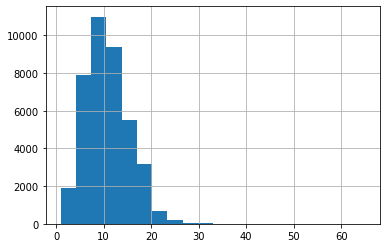

In [8]:
df['ingred_counts'] = df.ingredients.apply(len)
print(df['ingred_counts'].describe()[['count','min','mean','max']])
df['ingred_counts'].hist(bins=20)

In [9]:
df['ingred_counts'].value_counts().sort_index().head()

1      22
2     193
3     549
4    1128
5    1891
Name: ingred_counts, dtype: int64

There are 2 recipes with just one ingredient... These might be difficult to classify than those with more ingredients. Let's see what cuisines these are. 

In [10]:
df[df['ingred_counts']<2]

,cuisine,ingredients,ingred_counts
940,japanese,[sushi rice],1
2088,vietnamese,[dried rice noodles],1
6787,indian,[plain low-fat yogurt],1
7011,indian,[unsalted butter],1
8181,japanese,[udon],1
8852,thai,[sticky rice],1
8990,indian,[butter],1
10506,mexican,[corn tortillas],1
13178,thai,[grained],1
17804,southern_us,[lemonade concentrate],1


Ok so lots of cusines represented here and with fairly descriptive single ingredients in most cases. I think we shoul just leave these in.

## Cuisine sampling counts

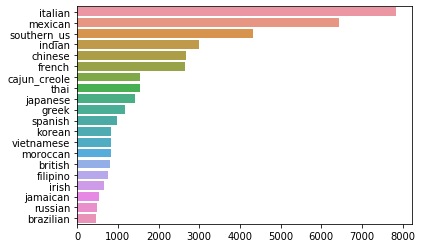

In [11]:
sns.barplot(df.cuisine.value_counts().values,
            df.cuisine.value_counts().index
           )

In [12]:
df.cuisine.value_counts(normalize=True).head()

italian        0.197063
mexican        0.161865
southern_us    0.108614
indian         0.075502
chinese        0.067205
Name: cuisine, dtype: float64

The classes are imbalanced, however, a naive classifier that predicts everything to be italian will only achieve over 20% accuracy. Brazilian has the least amount of recipes but there's still 500 examples of it. We might want to weight any classifier with more of the cuisines on the lower spectrum here. 

## Ingredient Stats

In [13]:
all_ingredients=[]
for ingredients in df.ingredients:
    all_ingredients+=ingredients
all_ingredients =pd.Series(all_ingredients)

In [14]:
print('there are {} ingredients, {} of which are unique'.format(len(all_ingredients),len(all_ingredients.unique())))

there are 428275 ingredients, 6714 of which are unique


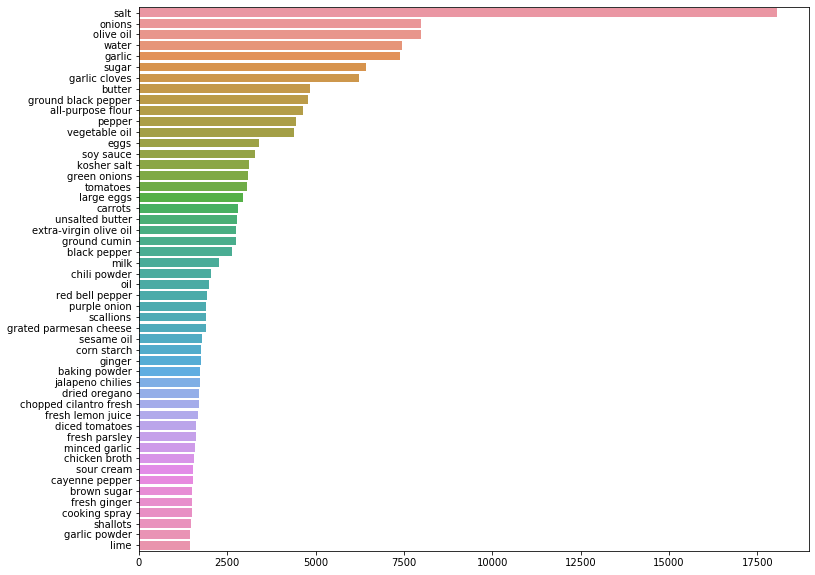

In [15]:
plt.figure(figsize=(12,10))
sns.barplot(x=all_ingredients.value_counts().head(50).values,y=all_ingredients.value_counts().head(50).index)

- Unsurprisingly salt is very common, probably in most cuisines. We see some different types of salts, such as kosher salt. The word kosher might be very useful though so we probably don't want to drop that descriptor. 
- Garlic shows up as garlic, minced garlic, garlic cloves, garlic powder. I'm not sure how much that distinguising helps predict cuisine...
- Overall not sure if there's any action to take with this info.


Let's look at the list of unique ingredients in more detail.

In [16]:
unique_ingredients = pd.DataFrame({'ingredient':all_ingredients.unique()})
unique_ingredients['ingred_length'] = unique_ingredients['ingredient'].apply(len)

In [17]:
unique_ingredients.sort_values('ingredient')

,ingredient,ingred_length
955,( oz.) tomato sauce,22
3073,( oz.) tomato paste,21
5200,(10 oz.) frozen chopped spinach,31
1988,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",56
5514,(14 oz.) sweetened condensed milk,33
3833,(14.5 oz.) diced tomatoes,25
5108,(15 oz.) refried beans,22
2077,1% low-fat buttermilk,21
3859,1% low-fat chocolate milk,25
1516,1% low-fat cottage cheese,25


In [18]:
unique_ingredients.sort_values('ingred_length',ascending=False).head(20)

,ingredient,ingred_length
5756,Pillsburyâ„¢ Crescent Recipe CreationsÂ® refrigerated seamless dough sheet,74
6015,KRAFT Mexican Style Shredded Four Cheese with a TOUCH OF PHILADELPHIA,69
952,bertolli vineyard premium collect marinara with burgundi wine sauc,66
6565,Hidden ValleyÂ® Farmhouse Originals Italian with Herbs Dressing,63
3899,Hidden ValleyÂ® Original Ranch SaladÂ® Dressing & Seasoning Mix,63
5816,hellmannÃ¢â‚¬â„¢ or best food canola cholesterol free mayonnais,63
4815,KRAFT Shredded Pepper Jack Cheese with a TOUCH OF PHILADELPHIA,62
3229,condensed reduced fat reduced sodium cream of mushroom soup,59
5735,condensed reduced fat reduced sodium cream of chicken soup,58
3881,i can't believ it' not butter! made with olive oil spread,57


- Not sure if the measurements of oz are necessary to keep
- Definitely some very specific longform ingredients. And in general we already saw there's varients on ingredients. So we need to think of a way to handle these variations while also preserving the distinguising factors of the long form. 

# Robustness to Similarities

Let's address the above concern by:

1. Create a new column where we simply lower the ingredients, replace spaces with underscores, and drop duplicates within recipes.

2. Create a new column where any grams above single are keep **as well as** split into separate words. Above transformations will also apply. This is where we will both keep the specifics as well as generalize the parts. 

We can train on both these corpus and see the different outcomes. We'll start with the second robust list but look out for the possible need to remove stop words.

In [19]:
import itertools
df['ingredients_original'] = df.ingredients.apply(lambda x: [s.lower().strip().replace(' ','_') for s in x])
df['ingredients_single'] = df.ingredients.apply(
    lambda x: [s.lower().strip().replace(' ','_') for s in x] + list(itertools.chain.from_iterable([s.lower().strip().split(' ') for s in x]))
)

In [20]:
df.head()

,cuisine,ingredients,ingred_counts,ingredients_original,ingredients_single
0,greek,"[romaine lettuce, black olives, grape tomatoes, garlic, pepper, purple onion, seasoning, garbanzo beans, feta cheese crumbles]",9,"[romaine_lettuce, black_olives, grape_tomatoes, garlic, pepper, purple_onion, seasoning, garbanzo_beans, feta_cheese_crumbles]","[romaine_lettuce, black_olives, grape_tomatoes, garlic, pepper, purple_onion, seasoning, garbanzo_beans, feta_cheese_crumbles, romaine, lettuce, black, olives, grape, tomatoes, garlic, pepper, pur..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, ground black pepper, thyme, eggs, green tomatoes, yellow corn meal, milk, vegetable oil]",11,"[plain_flour, ground_pepper, salt, tomatoes, ground_black_pepper, thyme, eggs, green_tomatoes, yellow_corn_meal, milk, vegetable_oil]","[plain_flour, ground_pepper, salt, tomatoes, ground_black_pepper, thyme, eggs, green_tomatoes, yellow_corn_meal, milk, vegetable_oil, plain, flour, ground, pepper, salt, tomatoes, ground, black, p..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, green chilies, grilled chicken breasts, garlic powder, yellow onion, soy sauce, butter, chicken livers]",12,"[eggs, pepper, salt, mayonaise, cooking_oil, green_chilies, grilled_chicken_breasts, garlic_powder, yellow_onion, soy_sauce, butter, chicken_livers]","[eggs, pepper, salt, mayonaise, cooking_oil, green_chilies, grilled_chicken_breasts, garlic_powder, yellow_onion, soy_sauce, butter, chicken_livers, eggs, pepper, salt, mayonaise, cooking, oil, gr..."
3,indian,"[water, vegetable oil, wheat, salt]",4,"[water, vegetable_oil, wheat, salt]","[water, vegetable_oil, wheat, salt, water, vegetable, oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pepper, onions, garlic paste, milk, butter, salt, lemon juice, water, chili powder, passata, oil, ground cumin, boneless chicken skinless thigh, garam m...",20,"[black_pepper, shallots, cornflour, cayenne_pepper, onions, garlic_paste, milk, butter, salt, lemon_juice, water, chili_powder, passata, oil, ground_cumin, boneless_chicken_skinless_thigh, garam_m...","[black_pepper, shallots, cornflour, cayenne_pepper, onions, garlic_paste, milk, butter, salt, lemon_juice, water, chili_powder, passata, oil, ground_cumin, boneless_chicken_skinless_thigh, garam_m..."


There's no missing values and all the recipes seem to be unique based on id. The recipes also range from 1 ingredient up to 65 ingredients with a mean of 10.

# Driving ingredients

We can easily determine the driving ingredients for each cuisine by pooling the ingredients together and running TF-IDF on the labelled corpus.

In [21]:
from gensim.utils import simple_preprocess, lemmatize
from gensim import models, corpora

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Original cleaned



In [22]:
def tfidf_ingreds(col):
    
    # first we pool the ingredients that are appearing in each cuisine
    cuisines = {}
    for cuisine in df.cuisine.unique():
        cuisines[cuisine]=[]
        sub_df = df.query('cuisine==@cuisine')
        for ingredients in sub_df[col]:
            cuisines[cuisine] += ingredients

    # now we create a dictionary of all the words for translations as needed and create the tfidf model
    tokens_2d = cuisines.values()
    mydict = corpora.Dictionary(tokens_2d)
    corpus = [mydict.doc2bow(token_line) for token_line in tokens_2d]
    # Create the TF-IDF model
    tfidf = models.TfidfModel(corpus, smartirs='ntc')
    
    # No let's unpack the model into a ingredient, frequency by cuisine and print the top 5 ingredients.
    for i,cuisine in enumerate(cuisines.keys()):
        words_freq_df = pd.DataFrame([[mydict[id], np.around(freq, decimals=2)] for id, freq in tfidf[corpus][i]],
                 columns=['ingredient','frequency']).sort_values('frequency',ascending=False)
        plt.figure(figsize=(6,1.5))
        sns.barplot(x = words_freq_df.frequency.iloc[:5],y=words_freq_df.ingredient.iloc[:5])
        plt.title(cuisine)

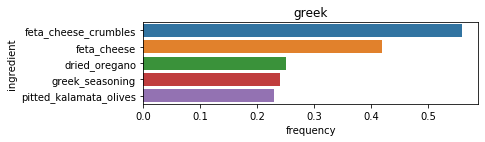

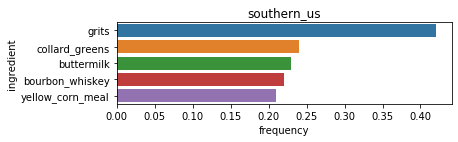

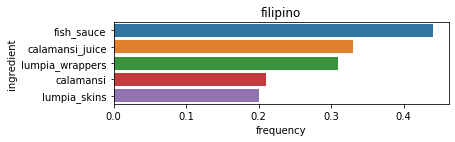

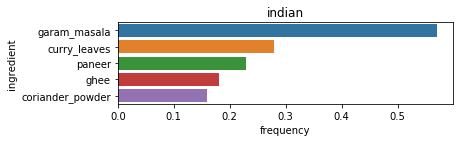

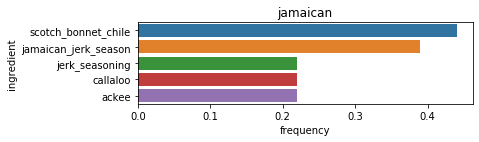

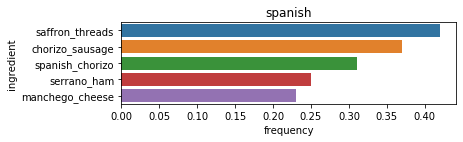

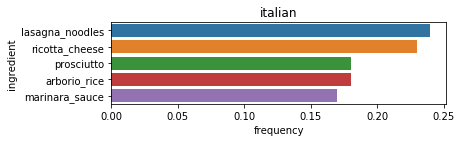

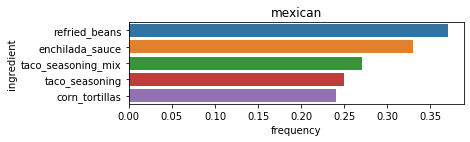

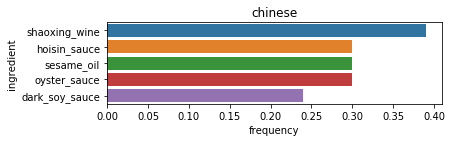

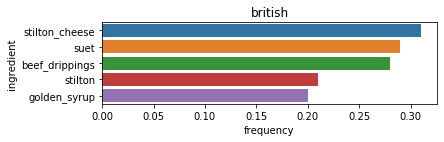

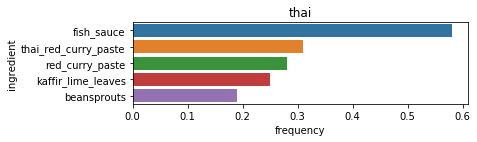

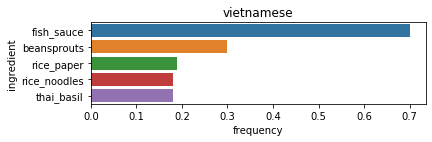

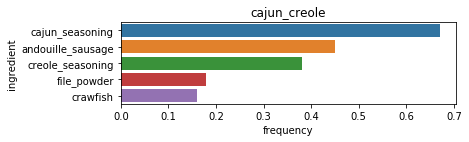

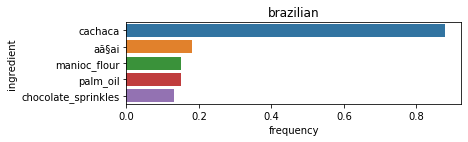

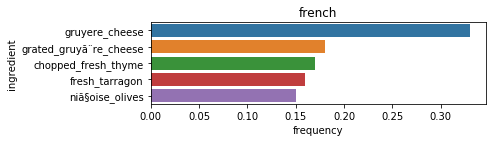

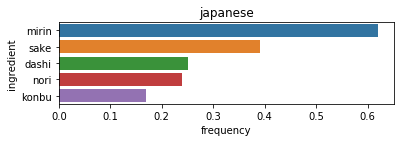

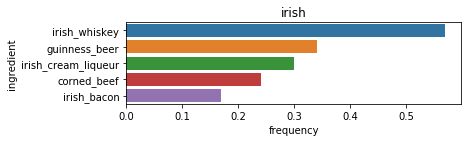

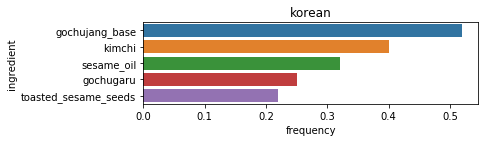

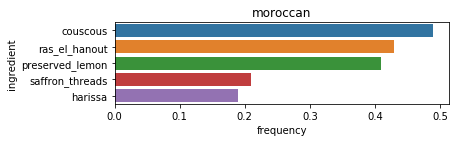

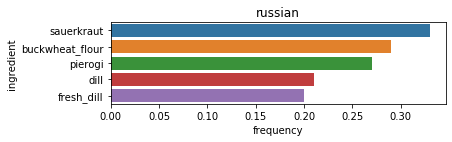

In [23]:
tfidf_ingreds('ingredients_original')

## Single-fied ingredients

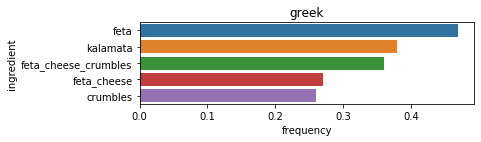

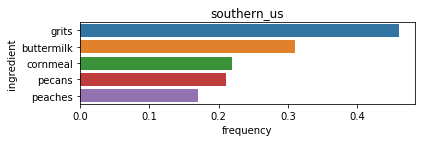

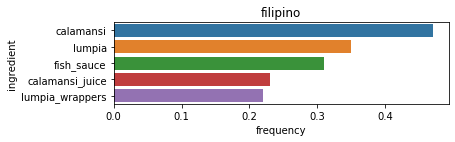

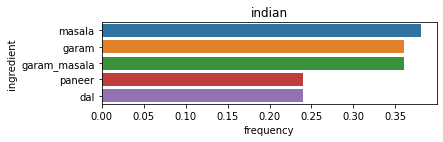

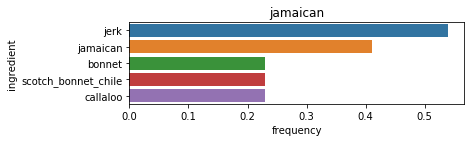

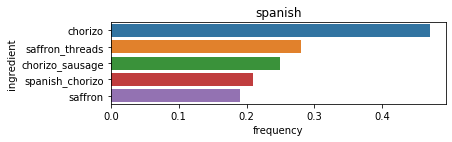

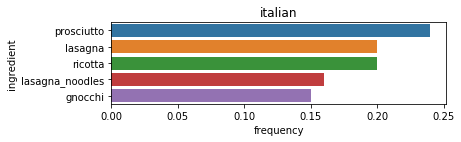

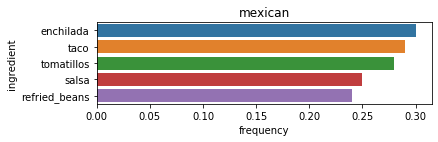

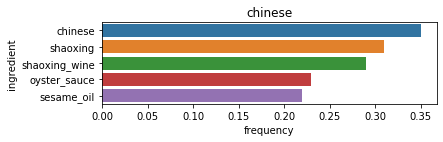

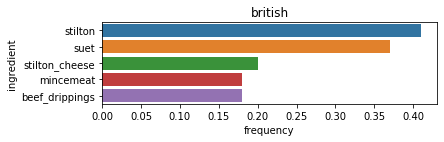

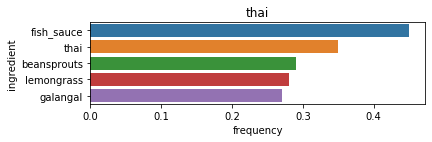

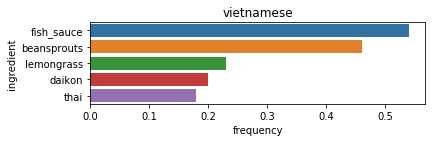

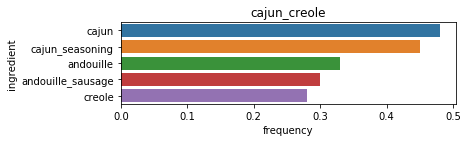

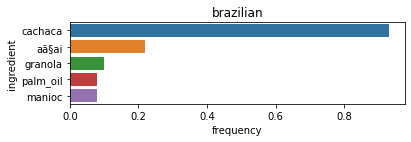

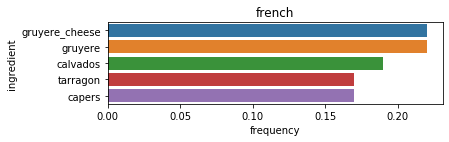

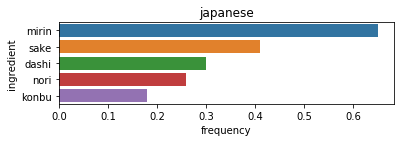

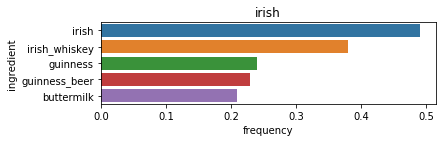

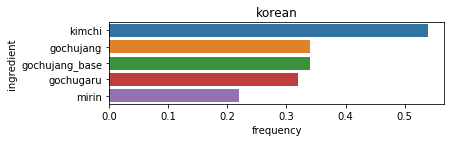

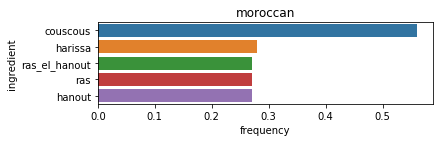

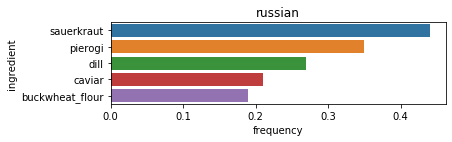

In [24]:
tfidf_ingreds('ingredients_single')

The single-fied ingredients definitely affected some of the tfidf scores. Let's continue to compare the performance of these two lists of ingredients as we move into predictive models below.

# Cuisine predictor with tfidf vectorizor feature extraction and Logistic Regression

TFIDF seems like a greate feature to train on since the ingredients are a non-ordered list of words. If we were predicting off of a different text document such as short stories where it might matter the order of words, we would want to try other models such as doc2vec.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score

In [26]:
train_df, test_df = train_test_split(
    df,
    test_size = .2,
    stratify = df['cuisine'],
    random_state = 42
)

In [27]:
tfidf_transformer = TfidfVectorizer(ngram_range = (1,1)).fit(train_df['ingredients_original'].apply(lambda x: " ".join(x)))

test_df_tfidf_X, test_df_tfidf_y = tfidf_transformer.transform(
    test_df['ingredients_original'].apply(lambda x: " ".join(x))), test_df['cuisine']

train_df_tfidf_X, train_df_tfidf_y = tfidf_transformer.transform(
    train_df['ingredients_original'].apply(lambda x: " ".join(x))), train_df['cuisine']

In [28]:
lg = LogisticRegression()
lg.fit(train_df_tfidf_X,train_df_tfidf_y)
pred_y = lg.predict(test_df_tfidf_X)
accuracy_score(test_df_tfidf_y, pred_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.764299182903834

This is pretty great prediction accuracy with the original recipe list! Let's try the single-fied ingredients.

In [29]:
tfidf_transformer = TfidfVectorizer(ngram_range = (1,1)).fit(df['ingredients_single'].apply(lambda x: " ".join(x)))

test_df_tfidf_X, test_df_tfidf_y = tfidf_transformer.transform(
    test_df['ingredients_single'].apply(lambda x: " ".join(x))), test_df['cuisine']
train_df_tfidf_X, train_df_tfidf_y = tfidf_transformer.transform(
    train_df['ingredients_single'].apply(lambda x: " ".join(x))), train_df['cuisine']

In [30]:
lg = LogisticRegression(solver='lbfgs',multi_class='auto')
lg.fit(train_df_tfidf_X,train_df_tfidf_y)
pred_y = lg.predict(test_df_tfidf_X)
accuracy_score(test_df_tfidf_y, pred_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.785166561910748

Great, more than 1% better prediction is coming from the single-fied ingredients. 

Let's compare a few different models. Borrowed some of this from Tyler's notebook cause I liked how clean it was.

In [31]:
models = [
    ("LogReg", LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)),
    ("Multi NB", MultinomialNB(alpha=0.01)),
    ("Support Vector", LinearSVC(penalty='l2')),
    ("Random Forest", RandomForestClassifier(n_estimators=100)),
    ("SGD Classifer", SGDClassifier(alpha=0.0001, penalty="elasticnet"))
]

In [32]:
from timeit import default_timer as time

for name, model in models:
    start = time()
    model.fit(train_df_tfidf_X,train_df_tfidf_y)
    train_accuracy = accuracy_score(train_df_tfidf_y,model.predict(train_df_tfidf_X))
    test_accuracy = accuracy_score(test_df_tfidf_y, model.predict(test_df_tfidf_X))
    print("Finished {} after {:.2f} s. Train, Test accuracy: {:.2f}, {:.2f}".format(name, time()-start,train_accuracy,test_accuracy))

Finished LogReg after 17.18 s. Train, Test accuracy: 0.84, 0.78
Finished Multi NB after 0.29 s. Train, Test accuracy: 0.83, 0.75
Finished Support Vector after 1.59 s. Train, Test accuracy: 0.90, 0.79
Finished Random Forest after 58.36 s. Train, Test accuracy: 1.00, 0.74
Finished SGD Classifer after 2.44 s. Train, Test accuracy: 0.80, 0.77


Everything is overfitting but the LinearSVC seems to get best test accuracy and is pretty fast compared to others. Let's gridsearch the hyperparameters of it to reduce overfitting and maximize test accuracy.

In [33]:
from sklearn.model_selection import GridSearchCV

In [38]:
hyperparameters = {
    "loss": ['squared_hinge', 'hinge'],
    "C": [0.1, 0.3, 1, 3, 10, 30, 100],
}

In [47]:
gs = GridSearchCV(
    estimator=LinearSVC(),
    param_grid=hyperparameters,
    scoring='accuracy',
    cv=5,
    error_score=np.nan
)

In [48]:
gs.fit(train_df_tfidf_X, train_df_tfidf_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:545: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 1, 3, 10, 30, 100],
                         'loss': ['squared_hinge', 'hinge'],
                         'penalty': ['l2', 'l1']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [52]:
best_model = gs.best_estimator_
best_model

LinearSVC(C=0.3, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

train_accuracy = accuracy_score(train_df_tfidf_y,best_model.predict(train_df_tfidf_X))
test_accuracy = accuracy_score(test_df_tfidf_y, best_model.predict(test_df_tfidf_X))
print("Train, Test accuracy: {:.2f}, {:.2f}".format(train_accuracy,test_accuracy))
    
y_pred = best_model.predict(test_df_tfidf_X)
print(classification_report(test_df_tfidf_y, y_pred))

Train, Test accuracy: 0.87, 0.79
              precision    recall  f1-score   support

   brazilian       0.84      0.56      0.67        93
     british       0.64      0.47      0.54       161
cajun_creole       0.79      0.74      0.77       309
     chinese       0.79      0.87      0.83       535
    filipino       0.77      0.56      0.65       151
      french       0.61      0.65      0.63       529
       greek       0.80      0.68      0.73       235
      indian       0.86      0.93      0.89       601
       irish       0.70      0.43      0.53       133
     italian       0.81      0.90      0.85      1568
    jamaican       0.84      0.77      0.81       105
    japanese       0.80      0.73      0.76       284
      korean       0.82      0.73      0.77       166
     mexican       0.90      0.93      0.91      1288
    moroccan       0.84      0.76      0.80       164
     russian       0.71      0.41      0.52        98
 southern_us       0.73      0.81      0.77     

## Confusion matrix for full dataset.

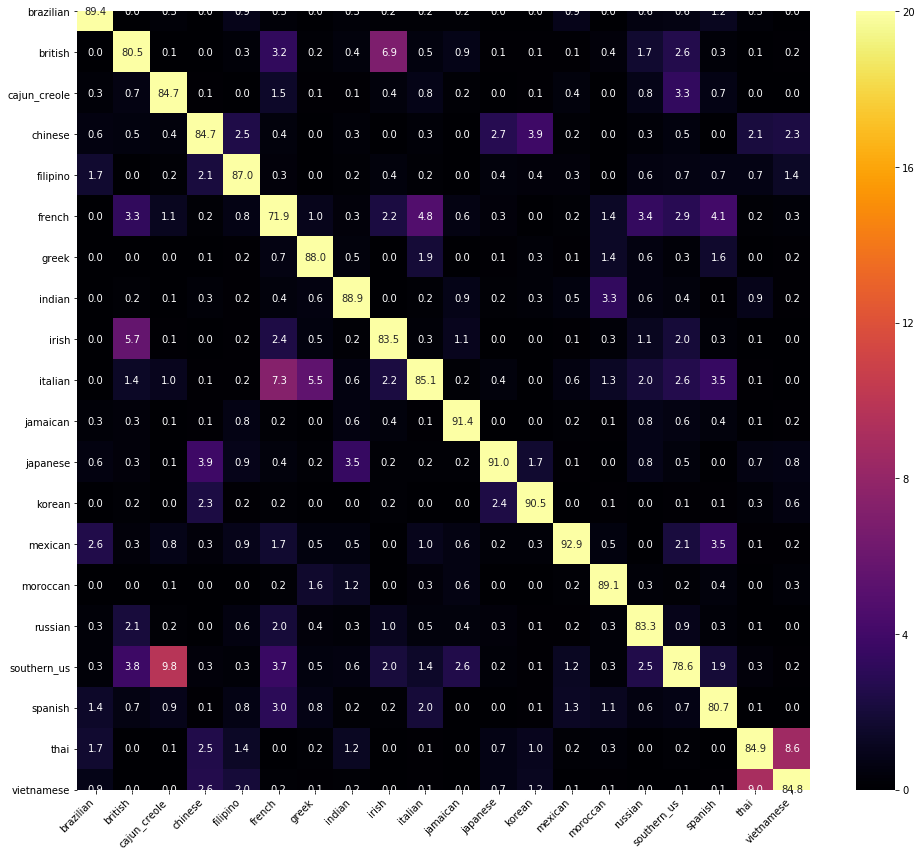

In [75]:
labels = np.sort(df.cuisine.unique())
cm = confusion_matrix(df['cuisine'],
                      best_model.predict(TfidfVectorizer().fit_transform(df['ingredients_single'].apply(lambda x: ' '.join(x)))))
cm_norm = cm/cm.sum(axis=0)
plt.figure(figsize=(14,12))
sns.heatmap(100*cm_norm, xticklabels=labels, yticklabels=labels,annot=True,fmt='.1f',cmap='inferno',vmax=20)
plt.gca().set_xticklabels(labels, rotation=45, ha='right')
plt.tight_layout()

This shows a lot of interesting relationships between cuisines around the world:

- southern food is related to british, creole, french, and jamaican
- italian is reated to french, greek, and spanish
- french is related to creole, italian, russian, southern, and spanish, 
- thai and vietnamse are strongly related, with some chinese mixed in.
- irish and british have some mixing
- spanish and mexican connection can be seen.

# Cuisine Predictor with doc2vec and sklearn classifiers

In [149]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

In [150]:
def get_corpus(sub_df):
    return [
        TaggedDocument(
            r['ingredients_single'],
            [r['cuisine']]
        ) for i,r in sub_df[['cuisine','ingredients_single']].iterrows()
    ]

In [151]:
train_corpus = get_corpus(train_df)
test_corpus = get_corpus(test_df)

In [152]:
train_corpus[0]

TaggedDocument(words=['black_pepper', 'paprika', 'garlic_cloves', 'tomatoes', 'garam_masala', 'chickpeas', 'coriander', 'olive_oil', 'salt', 'lentils', 'tumeric', 'chili_powder', 'chopped_onion', 'cumin', 'black', 'pepper', 'paprika', 'garlic', 'cloves', 'tomatoes', 'garam', 'masala', 'chickpeas', 'coriander', 'olive', 'oil', 'salt', 'lentils', 'tumeric', 'chili', 'powder', 'chopped', 'onion', 'cumin'], tags=['indian'])

In [153]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [154]:
# train_corpus = gensim.utils.simple_preprocess(full_string)
model = Doc2Vec(
    min_count=2,
    epochs=40,
    dm=0,
    negative=5,
    hs=0,
    sample=0,
    workers=cores
)
model.build_vocab(train_corpus)
print('Training doc2vec model...')
model.train(
    train_corpus,
    total_examples=model.corpus_count,
    epochs=model.epochs
)

Training doc2vec model...


In [155]:
def vec_for_learning(corpus):
    targets, features = zip(
        *[(recipe.tags[0], model.infer_vector(recipe.words, steps=10)) for recipe in corpus]
    )
    return targets, features

In [156]:
train_y, train_X = vec_for_learning(train_corpus)
test_y, test_X = vec_for_learning(test_corpus)

In [158]:
lg = LogisticRegression()
lg.fit(train_X,train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [159]:
y_pred = lg.predict(test_X)

In [160]:
accuracy_score(test_y, y_pred)

0.7372721558768071

In [162]:
rfc = RandomForestClassifier()
rfc.fit(train_X,train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [163]:
y_pred = rfc.predict(test_X)

In [164]:
accuracy_score(test_y, y_pred)

0.7014456316781899